### Изработила: Ангела Андоновски 93/2019

<h1><center>Cliff Walking</center></h1>

## Објаснување на проблемот
Cliff Walking проблемот претставува типичен пример од областа на Reinforcement learning каде целта е агентот од стартната позиција да стигне до крајната позиција (goal) притоа поминувајќи го ридот и да избегне паѓање од него.
Koристејќи го Q learning алгоритмот, агентот го надградува своето знаење за околината фокусирајќи се на наградите кои ги добил од преземаните акции, целејќи кон тоа да ја најде оптималната патека до целта и вредноста на наградата да биде најголема. Агентот балансира помеѓу истражување на нови патеки и користење на познати патеки за да го подобри донесувањето на одлуки со текот на времето, поточно да научи како да го избегнува ридот и да ја достигне крајната дестинација.

Околината е со димензии 4x12, а играта започнува со тоа што агентот е на позиција (3,0) и треба да стигне до крајната позиција (3,11). Кога агентот ја достигнува целта, се враќа на почетната позиција.
Ридот на мапата е лоциран на позициите (3,1...10). Доколку агентот се обиде да стапне на овие позиции, се враќа на стартната позиција. Агентот се движи се додека не ја достигне крајната цел. 

In [2]:
#Импортирање на потребни библиотеки
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output
import random


In [3]:
# од библиотеката gymnasium се повикува функцијата make со која се креира околината во која ќе работиме
env = gym.make('CliffWalking-v0')
env 

<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>

## Визуелизација на околината

Во овој дел даваме визуелен приказ на околината во која ќе се движи агентот и ќе се обиде да ја најде оптималната патека до целта, притоа избегнувајќи ги препреките, што во овој случај е самиот рид (cliff). Со црвена боја на сликата подолу е означена забранетата територија за агентот, поточно ридот и доколку агентот стапне на некое од црвените полиња е казнет. Со жолта боја е означена почетната позиција, од каде агентот почнува да се движи, а со зелена боја е означена целта. Останатите полиња се слободна терирорија на движење на агентот.

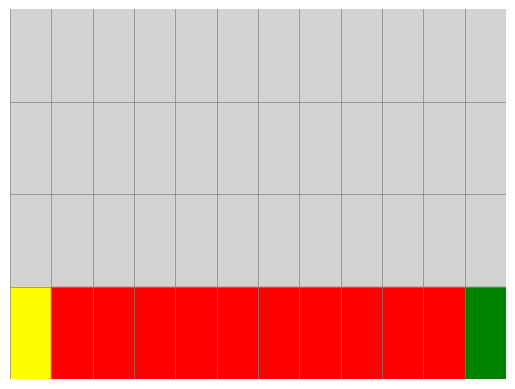

In [4]:
# Дефинирање на мапата 
grid_description = [
    "FFFFFFFFFFFF",
    "FFFFFFFFFFFF",
    "FFFFFFFFFFFF",
    "SFFFFFFFFFFG"
]

# Дефинирање на боите согласно типот на келијата на мапата
colors = {
    'S': 'yellow',  # Start
    'G': 'green',   # Goal
    'F': 'lightgrey', # Слободно движење
    'C': 'red'      # Рид
}

# Креирање на мапата
figure, axis = plt.subplots()

# Пополнување на келиите со бои
for row, row_description in enumerate(grid_description):
    for col, cell in enumerate(row_description):
        # Replace the 'F' on the cliff with 'C' for visual representation
        actual_cell = 'C' if (row == 3 and 1 <= col <= 10) else cell
        axis.add_patch(plt.Rectangle((col, -row - 1), 1, 1, color=colors[actual_cell]))

# Исцртување на мапата
for i in range(len(grid_description[0])):
    axis.axhline(-i - 1, color='gray', linewidth=0.5)
    axis.axvline(i, color='gray', linewidth=0.5)

# Ограничување на мапата
axis.set_xlim(0, len(grid_description[0]))
axis.set_ylim(-len(grid_description), 0)
axis.axis('off')

# Приказ на мапата
plt.show()


## Action Space
Формата на една акција може да биде (1,) во ранг {0,3} индицирајќи во која насока се движи агентот каде:
- 0: ГОРЕ
- 1: ДЕСНО
- 2: ДОЛЕ
- 3: ЛЕВО

## Observation Space 
Вкупниот број на состојби е 4 x 12, од кои дозволени состојби се 3 x 12, со што агентот не може да биде во ридот или на целта.

In [5]:
num_states = env.observation_space.n
num_actions = env.action_space.n

print("Број на состојби:", num_states)
print("Број на акции:", num_actions)

Број на состојби: 48
Број на акции: 4


## Q табела
Q table е матрица која се користи во Reinforcement learning за да се претстават естимираните награди (rewards) добиени од преземаните акции на агентот при специфични состојби, притоа водејќи го агентот кон целта. Секоја ќелија во табелата, означена како Q(state,action), ја квантифицира очекуваната идна награда(reward) која ќе се добие при преземање дадена акција која доведува до дадена состојба, овозможувајќи му на агентот да избере акции кои ја максимизираат оваа награда со текот на времето. Q табелата се ажурира со користење на алгоритам како што е Q Learning, при што вредностите итеративно се усовршуваат врз основа на искуството на агентот и набљудуваните резултати од неговите претходни акции, со цел на крајот да се спојат до оптималната action-value функција.

In [6]:
#Иницијализација на Q табела
Q_table = np.zeros((env.observation_space.n, env.action_space.n))
print(Q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## Хиперпараметри
Хиперпараметрите во Q learning се прилагодливи вредности кои го контролираат процесот на учење, влијаат на тоа колку брзо агентот учи од новодобиените информации, ги балансира идните награди(rewards), и истражува нови акции наспроти користење на веќе познати стратегии.
1. Аlpha (learning rate): 
    - Цел:детерминира т.е. одлучува колку од новите информации ќе ги прими агентот наспроти старите информации;
    - Ранг: 0.1-0.6;
    - Употреба: Ако агентот учи премногу бавно, вредноста на learning rate-от се зголемува, а во спротивен случај се намалува;
2. Gamma (discount factor):
    - Цел: Баланс на моменталната и идните награди;
    - Ранг: 0.8-0.99;
    - Употреба: Кога моменталните одлуки силно влијаат врз долготрајниот успех на агентот, поголема вредност на gamma помага да се балансираат наградите;
3. Epsilon (exploration rate):
    - Цел: одредување на компромисот помеѓу истражувањето (exploration) и експлоатацијата (exploitation);
    - Почетна вредност: 0.8-1.0;
    - Употреба: Се намалува со текот на времето, но вредноста зависи од бројот на епизоди;
    - Крајна вредност: Треба да биде ниска, но не и 0;
4. Epsilon decay rate: 
    - Цел: го контролира намалувањето на вредноста на epsilon;
    - Употреба: се сетира врз основа на вкупниот број на епизоди, т.е. се пресметува според следната формула:
          $ \frac{initialEpsilon-finalEpsilon}{episodes} $ ;
5. Епизоди:
    - Употреба: При решавање на овој проблем не се потребни голем број на епизоди и рангот на овој хиперпараметар вообичаено варира 100-1000 епизоди, врз основа на тоа дали агентот конзистентно ја достигнува целта без да падне од ридот.
 

In [7]:
ALPHA = 0.3
#EPSILON = 0.1
EPSILON = 0.9
RENDER_AT_EPISODE = 10
EPISODES = 500
GAMMA = 0.99
epsilon_decay_rate=0.003

## Epsilon Greedy Policy 

- Exploration: Во овој дел се генерира рандом број меѓу 0 и 1, а epsilon e threshold вредност помеѓу 0 и 1. Ако случајно генерираниот број е помал од epsilon, агентот одбира акција по случаен избор. Ова му овозможува на агентот да ја истражи околината, испробувајќи акции кои не биле применети до тогаш или врз база на неговото моментално знаење му изгледаат субоптимални. Целта на exploration е агентот да открие нови стратегии кои би му донеле поголеми награди(rewards);
- Exploitation: Во овој дел се преминува доколку рандом генерираниот број е поголем од epsilon, при што агентот презема акција со највисока естимирана награда, базирајќи се на моменталната Q табела. Целта на exploitation е агентот да го користи неговото моментално знаење за да ја направи најдобрата можна одлука и да ја максимизира наградата.

### Epsilon хиперпараметар
Во некои проблеми од oбласта на Reinforcement learning, epsilon хиперпараметарот е поставен како константна вредност при дефинирањето на хиперпараметрите и во понатамошното тренирање на агентот, тој не се менува. Во други проблеми, овој хиперпараметар има динамична вредност и истиот се менува од епизода во епизода, притоа намалувајќи ја својата вредност, а при дефинирањето на хиперпараметрите во овој случај, се дефинира само почетната т.е. иницијалната вредност на epsilon.
- Epsilon константа: Поставувајќи го epsilon како константна вредност, на пр. 0.1, тоа означува дека 10% од времето, независно од тоа колку научил за околината, агентот презема случајно одбрана акција. Во останатите 90% од времето агентот одбира акција со највисоко естимирана Q вредност. Овој пристап се користи во статични околини.
- Dynamic epsilon: Применувајќи го овој пристап, вредноста на еpsilon на почетокот е висока и се намалува со текот на времето, притоа користејќи ја стратегијата да агентот иницијално да се фокусира на истражување на околината (exploration). Како агентот ја учи околината, вредноста на epsilon постепено се намалува, насочувајќи се кон користење на своето знаење (exploitation). Со ова агентот сѐ повеќе се ослонува на стекнатото знаење за да донесува одлуки, бирајќи акции за кои смета дека ќе донесат највисока награда базирајќи се на Q вредностите. Ваквиот начин на дефинирање на epsilon е поприменлив. 

In [8]:
def epsilon_greedy_policy(observation_idx, Q_table, epsilon):
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q_table[observation_idx])
    return action

In [9]:
# Помошна метода за добивање на индексот на observation
def get_observation_idx(observation):
    if type(observation) is tuple:
        observation_idx = observation[0]
    else:
        observation_idx = observation
    return observation_idx

## Имплементација на Q learing алгритмот

Q learning e Reinforcement learning algorithm кој се користи да се пронајдат оптималните action-selection правила за секој конечен Markov decision process. Работи на тој начин што ја учи action-value методата која резултира со преземање на одредена акција во одредена состојба, следејќи ги оптималните правила.
Во Q Learning алгоритмот агентот ги усовршува Q вредностите, користејќи ја наградата која ја добил за моменталната акција и најголемата Q вредност од следната состојба. Агентот учи според следната формула:
- $ Q(s, a) \leftarrow Q(s, a) + \alpha \left[R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]$

    - $ Q(s, a) $ e моменталната естимирана action value;
    - $ \alpha $ e learning rate;
    - $ R(s, a) $ e наградата(reward) добиена по извршување на некоја акција;
    - $ \gamma $ e discount factor;
    - $ \max_{a'} Q(s', a') $ е најголемата Q вредност за следната состојба
Овој процес му овозможува на алгоритмот итеративно да ги подобри своите претпоставки за Q вредностите, конвергирајќи кон оптималната action-value метода при истражување на околината. 

In [10]:
# иницијализација на листа plotting_rewards каде се складираат средните вредности од rewards добиени во секои 10 итерации
plotting_rewards=[]
# иницијализација на променлива со цел да се чува сумата од добиените rewards
sum_rewards=0
# итерирање низ секоја епизода
for episode in range(EPISODES):
    #ресетирање на околината на почеток на секоја епизода и земање на почетната обзервација
    observation = env.reset()
    done = False
    #rewards = 0
    rewards=[]
    # агентот учи во истата епизода сѐ додека не дојде до целта
    while not done:
        # конвертирање на обзервацијата во индекс кој се користи во Q табелата
        observation_idx=get_observation_idx(observation)
        # одбирање на акција врз основа на epsilon greedy policy (exploaration или exploitation)
        action = epsilon_greedy_policy(observation_idx, Q_table, EPSILON)

        # извршување на одбраната акција во околината 
        next_observation, reward, done, *_ = env.step(action)
        # update-ирање на Q вредноста за добивање на моменталниот state-action пар врз база на добиената награда и максималната Q вредност за следната состојба
        Q_table[observation_idx][action] = Q_table[observation_idx][action] + ALPHA * (reward + GAMMA * np.max(Q_table[next_observation]) - Q_table[observation_idx][action])
        # update-ирање на обзервацијата за следната состојба 
        observation = next_observation
        #rewards += reward
        rewards.append(reward)
    #update-ирање на epsilon користејќи го еpsilon decay rate за да се намали истражувањето на агентот со текот на времето, целејќи кон еxploitation
    EPSILON=max(EPSILON-epsilon_decay_rate,0)
    
   # if EPSILON==0:
   #     LEARNING_RATE=0.0001
    sum_rewards += sum(rewards)
    # На секои 10 епизоди се пресметува средната вредност на наградите и се вметнува во погоре иницијализираната листа plotting_rewards
    if episode % 10 == 0:
        mean_reward = sum_rewards / 10
        plotting_rewards.append(mean_reward)
        sum_rewards = 0

    print(f"Episode {episode} finished with reward: {sum(rewards)}")



Episode 0 finished with reward: -37253
Episode 1 finished with reward: -3650
Episode 2 finished with reward: -25112
Episode 3 finished with reward: -5215
Episode 4 finished with reward: -264
Episode 5 finished with reward: -3094
Episode 6 finished with reward: -19632
Episode 7 finished with reward: -4918
Episode 8 finished with reward: -966
Episode 9 finished with reward: -13224
Episode 10 finished with reward: -777
Episode 11 finished with reward: -6578
Episode 12 finished with reward: -4979
Episode 13 finished with reward: -10604
Episode 14 finished with reward: -3319
Episode 15 finished with reward: -8869
Episode 16 finished with reward: -4543
Episode 17 finished with reward: -3229
Episode 18 finished with reward: -2386
Episode 19 finished with reward: -16459
Episode 20 finished with reward: -8744
Episode 21 finished with reward: -1481
Episode 22 finished with reward: -10374
Episode 23 finished with reward: -5682
Episode 24 finished with reward: -1729
Episode 25 finished with reward

In [11]:
max_q_values = np.max(Q_table, axis=1)
best_actions = np.argmax(Q_table, axis=1)

for state, (max_q_value, best_action) in enumerate(zip(max_q_values, best_actions)):
    print(f"For state {state}, the maximum Q-value is {max_q_value}, and the corresponding action is {best_action}")

For state 0, the maximum Q-value is -13.125416191154194, and the corresponding action is 1
For state 1, the maximum Q-value is -12.24789653559024, and the corresponding action is 1
For state 2, the maximum Q-value is -11.361512617611062, and the corresponding action is 1
For state 3, the maximum Q-value is -10.466174497706245, and the corresponding action is 1
For state 4, the maximum Q-value is -9.561792475746495, and the corresponding action is 2
For state 5, the maximum Q-value is -8.648275244091895, and the corresponding action is 1
For state 6, the maximum Q-value is -7.72553055287362, and the corresponding action is 2
For state 7, the maximum Q-value is -6.793465206989331, and the corresponding action is 1
For state 8, the maximum Q-value is -5.8519850586459405, and the corresponding action is 1
For state 9, the maximum Q-value is -4.900995009478526, and the corresponding action is 2
For state 10, the maximum Q-value is -3.940398999888103, and the corresponding action is 2
For st

Во овој дел се врши анализа на Q табелата после тренирањето на агентот, специфично за да се добие максималната Q вредност и соодветната најдобра акција за секоја состојба.
Како заклучок од добиените резултати може да се увиде дека растот на Q вредноста низ состојбите укажува на тоа дека агентот се приближува кон целта со избирање на акции кои ја намалуваат казната, првично избирајќи ја акцијата '1' (десно) како најповолна. Оваа акција претставува оптимален избор за движење кон целта. Во states, кога Q вредноста е еднаква на 0 означува дека агентот ја достигнал целта, односно нема повеќе акции кои би му донеле награда. За крај, можеме да заклучиме дека агентот бира внимателен пристап за максимизирање на наградите во рамките на ограничувањата на динамиката на околината. 

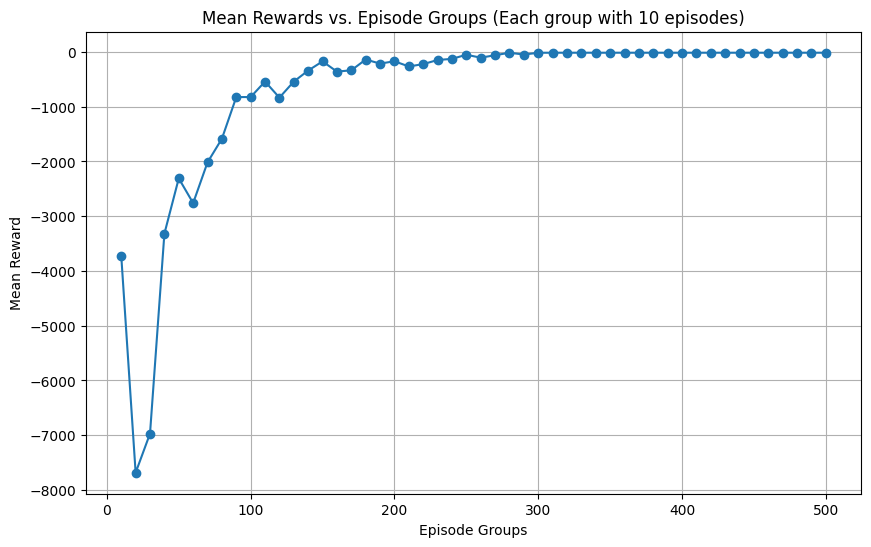

In [12]:
episodes_per_group = 10
episode_numbers = range(episodes_per_group, EPISODES + 1, episodes_per_group)

plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, plotting_rewards, marker ='o', linestyle='-')
plt.title('Mean Rewards vs. Episode Groups (Each group with 10 episodes)')
plt.xlabel('Episode Groups')
plt.ylabel('Mean Reward')
plt.grid(True)
plt.show()

На почетокот, може да се заклучи дека агентот добива голема казна, што е и очекувано бидејќи тогаш тој ја истражува околината. Со текот на времето, вредноста на наградата се постепено се зголемува. Наоѓањето на оптималната патека по 300та епизода е позитивен исход за агентот. Тоа укажува дека агентот ефективно учи од своите интеракции со околината и се прилагодува на оптималниот сет на акции. Понатамошно подобрување или потврдување на процесот на учење може да се добие преку експериментирање со различни множества хиперпараметри или инкорпорирање на дополнителни метрики за евалуација на перформансите.

In [13]:
n_episodes=1
env = gym.make('CliffWalking-v0', render_mode="human")
for episode in range(n_episodes):
    observation = env.reset()
    done = False
    while not done:
        env.render() 
        observation_idx=get_observation_idx(observation)
        action = epsilon_greedy_policy(observation_idx, Q_table, EPSILON)
        next_observation, reward, done, *_ = env.step(action)
        observation = next_observation
env.close()

## SАRSA Algorithm
SARSA(State-Action-Reward-State-Action) aлгоритмот e Reinforcement learning алгоритам, каде агентот ги учи правилата врз база на акцијата која ја презема и добиената награда од самата акција. Правилото се update-ира врз база на моменталната состојба, преземаната акција, добиената награда, следната состојба и следната акција. Овој пристап му дозволува на алгоритмот да ги научи најдобрите потези, притоа "размислувајќи" за последиците кои би биле добиени со преземање на следната акција.

### Разлики меѓу Q learning и SARSA
- SARSA e on-policy, учи од акциите кои моментално ги презема, а Q learning e off-policy, т.е. учи од можните најдобри акции. 
- SARSA се update-ира врз база на следната можна акција, внимавајќи на моменталните правила. Q learning се update-ира користејќи ги најдобрите можни следни акции, стремејќи се кон оптимален исход.
- SARSA е повнимателен алгоритам со тоа што избегнува ризични акции, учејќи ја моменталната стратегија, додека Q learning e оптимистичен и се фокусира на најдобриот резултат и потенцијално игнорирање на ризици.

In [14]:
env_Sarsa = gym.make('CliffWalking-v0')
env_Sarsa 

<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>

In [15]:
Q_table_Sarsa = np.zeros((env_Sarsa.observation_space.n, env_Sarsa.action_space.n))
print(Q_table_Sarsa)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [16]:
ALPHA = 0.3
#EPSILON = 0.1
EPSILON = 0.9
RENDER_AT_EPISODE = 10
EPISODES = 500
GAMMA = 0.99
epsilon_decay_rate=0.003

In [17]:
def epsilon_greedy_policy(observation_idx, Q_table_Sarsa, epsilon):
    if random.random() < epsilon:
        action = env_Sarsa.action_space.sample()
    else:
        action = np.argmax(Q_table_Sarsa[observation_idx])
    return action

In [18]:
# Помошна метода за добивање на индексот на observation
def get_observation_idx(observation):
    if type(observation) is tuple:
        observation_idx = observation[0]
    else:
        observation_idx = observation
    return observation_idx

In [19]:
plotting_rewards_Sarsa=[]
sum_rewards=0
for episode in range(EPISODES):
    observation = env_Sarsa.reset()
    done = False
    #rewards = 0
    rewards=[]
    while not done:
        
        observation_idx=get_observation_idx(observation)
        action = epsilon_greedy_policy(observation_idx, Q_table_Sarsa, EPSILON)
        
        next_observation, reward, done, *_ = env_Sarsa.step(action)
        
        next_observation_idx=get_observation_idx(next_observation)
        new_action=epsilon_greedy_policy(next_observation_idx,Q_table_Sarsa,EPSILON)
        
        Q_table_Sarsa[observation_idx][action] = Q_table_Sarsa[observation_idx][action] + ALPHA * (reward + GAMMA * (Q_table_Sarsa[next_observation_idx][new_action]) - Q_table_Sarsa[observation_idx][action])
        observation = next_observation
        action=new_action
        #rewards += reward
        rewards.append(reward)
    EPSILON=max(EPSILON-epsilon_decay_rate,0)
    
   # if EPSILON==0:
   #     LEARNING_RATE=0.0001
    sum_rewards += sum(rewards)
    if episode % 10 == 0:
        mean_reward = sum_rewards / 10
        plotting_rewards_Sarsa.append(mean_reward)
        sum_rewards = 0

    print(f"Episode {episode} finished with reward: {sum(rewards)}")


Episode 0 finished with reward: -9204
Episode 1 finished with reward: -765
Episode 2 finished with reward: -10579
Episode 3 finished with reward: -6850
Episode 4 finished with reward: -12240
Episode 5 finished with reward: -3564
Episode 6 finished with reward: -4009
Episode 7 finished with reward: -6535
Episode 8 finished with reward: -636
Episode 9 finished with reward: -1130
Episode 10 finished with reward: -12013
Episode 11 finished with reward: -1012
Episode 12 finished with reward: -10725
Episode 13 finished with reward: -15106
Episode 14 finished with reward: -1507
Episode 15 finished with reward: -1183
Episode 16 finished with reward: -9424
Episode 17 finished with reward: -6599
Episode 18 finished with reward: -676
Episode 19 finished with reward: -393
Episode 20 finished with reward: -1001
Episode 21 finished with reward: -664
Episode 22 finished with reward: -1159
Episode 23 finished with reward: -6450
Episode 24 finished with reward: -3518
Episode 25 finished with reward: -1

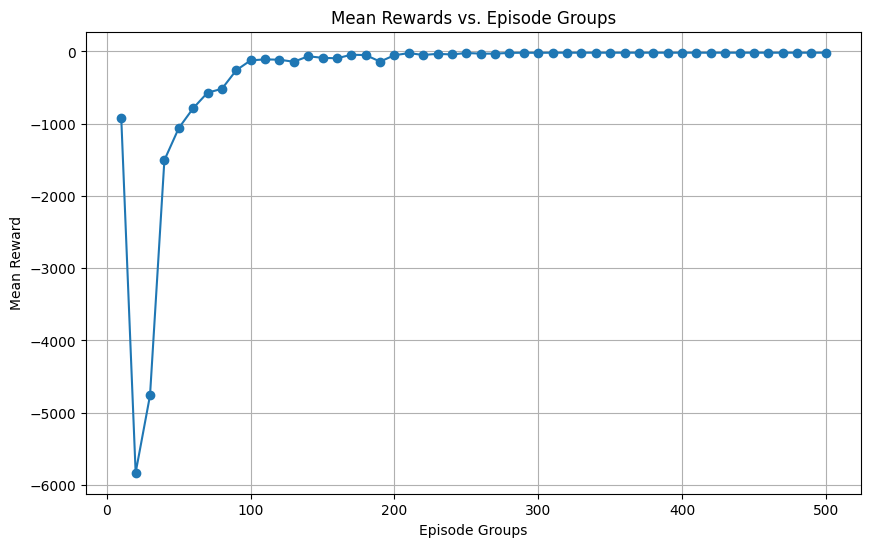

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, plotting_rewards_Sarsa, marker ='o', linestyle='-')
plt.title('Mean Rewards vs. Episode Groups')
plt.xlabel('Episode Groups')
plt.ylabel('Mean Reward')
plt.grid(True)
plt.show()

In [21]:
env_Sarsa = gym.make('CliffWalking-v0', render_mode="human")
n_episodes=1
for episode in range(n_episodes):
    observation = env_Sarsa.reset()
    done = False
    #rewards = 0
    rewards=[]
    while not done:
        env_Sarsa.render() 
        
        observation_idx=get_observation_idx(observation)
        action = epsilon_greedy_policy(observation_idx, Q_table_Sarsa, EPSILON)
        
        next_observation, reward, done, *_ = env_Sarsa.step(action)
        
        next_observation_idx=get_observation_idx(next_observation)
        new_action=epsilon_greedy_policy(next_observation_idx,Q_table_Sarsa,EPSILON)
        
        observation = next_observation
        action=new_action
env_Sarsa.close()

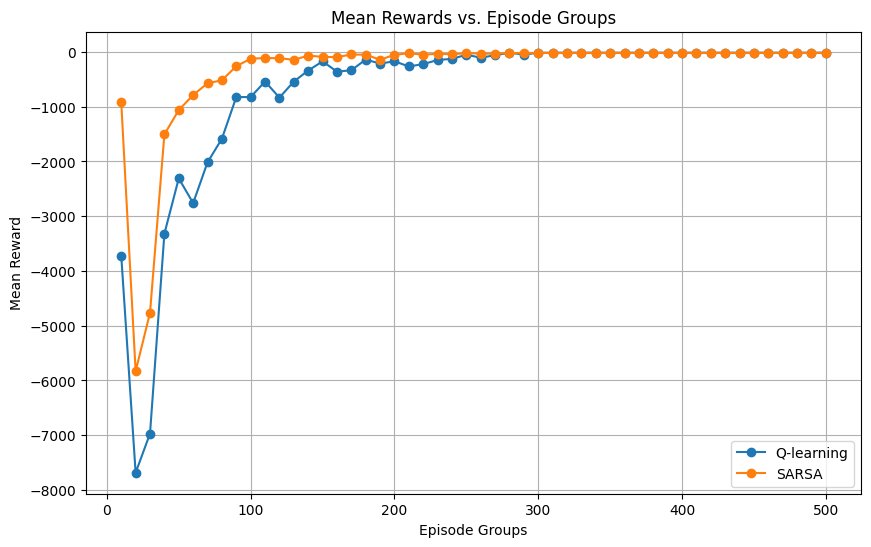

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, plotting_rewards, marker='o', linestyle='-', label='Q-learning')
plt.plot(episode_numbers, plotting_rewards_Sarsa, marker='o', linestyle='-', label='SARSA')
plt.title('Mean Rewards vs. Episode Groups')
plt.xlabel('Episode Groups')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

Од добиениот график може да се заклучи дека и двата алгоритми се карактеризираат со значителна флуктуација во средната вредност на наградите кои ги добиваат на почетокот на учењето, што е очекувано бидејќи агентот ја истражува околината и започнува да учи. 
- Q-learning првично прикажува понестабилна крива на учење, со поголеми промени во просечната награда пред да се стабилизира. Ова може да е показател на неговата off-policy nature, каде учи од хипотетички акции што потенцијално води кон поголемо истражување и варијации во перформансите;
- SARSA, од друга страна, покажува помали флуктуации и се чини дека побрзо се стабилизира. Ова е карактеристично за алгоритмите кои се on-policy nature, кои учат врз основа на тековните стратегии и на тој начин може да имаат помазна крива на учење бидејќи тие обично преземаат побезбедни акции;
- Споредбено, двата алгоритми со текот на времето достигнуваат слични, речиси исти нивоа на просечна награда и овој факт сугерира дека и двата алгортими добро функционираат според структурата на наградата на околината.

## Monte-Carlo Algorithm

- Мonte Carlo e reinforcement leaning алгоритам со кој агентот создава искуство преку извршување на правилата во околината и евидентирање на посетените состојби, преземаните акции и добиените награди. Овие секвенци за стекнување искуство се познати како епизоди. Една епизода мора да заврши за да се примени MC алгоритмот.
- Кај MC алгоритамот се врши пресметка на return или така наречено враќање или поврат. Повратот (return) е вкупната "намалена" награда добиена од time step до крајот на епизодата. Притоа, за time step t, повратот Gt се пресметува како:  Gt=Rt+1 + γ*Rt+2 + γ^2*Rt+3..., каде Rt+1 е награда добиена после преземање на акција за време t, а γ или gamma e discount factor  (0 ≤ γ ≤ 1) кој ја детерминира моменталната вредност на идните награди. 
- Value Estimation: Вредноста на состојбата или акцијата е естимирана со тоа што се бара просечна вредност на повратите (returns) кои биле обзервирани по таа состојба или акција. За проценка на вредноста на состојбата (state value), ова значи пресметка на просечниот поврат за секоја состојба низ секоја од епизодите. За проценка на вредноста на акцијата (action value), на сличен начин, вклучува просечна вредност на повратот по секоја акција преземена во одредена состојба.
- MC методите се јасни и моќни, особено кога се работи со околини со висока несигурност и сложеност. Сепак, тие можат бавно да конвергираат и да бараат многу примероци, бидејќи варијансата на повратот може да биде висока. Дополнително, бидејќи чекаат до крајот на епизодата за да ги ажурираат проценетите вредности, тие не се погодни за неепизодни (продолжени) задачи без модификации.

 

In [23]:
env_MC = gym.make('CliffWalking-v0')

In [24]:
def epsilon_greedy_policy(observation_idx, Q_table, epsilon):
    if random.random() < epsilon:
        action = env_MC.action_space.sample()
    else:
        action = np.argmax(Q_table[observation_idx])
    return action


In [25]:
def get_observation_idx(observation):
    if type(observation) is tuple:
        observation_idx = observation[0]
    else:
        observation_idx = observation
    return observation_idx

In [33]:
# Hyperparameters
alpha = 0.3
epsilon = 0.9
epsilon_decay = 0.003
min_epsilon = 0.1
gamma = 0.99
episodes = 500
plotting_rewards_MonteCarlo=[]
sum_rewards=0

In [34]:
# Q-table
Q_table = np.zeros((env_MC.observation_space.n, env_MC.action_space.n))

for episode in range(episodes):
    observation = env_MC.reset()
    done = False
    episode_steps = []
    rewards=[]
    
    
    while not done:
        state = get_observation_idx(observation) 
        action = epsilon_greedy_policy(state, Q_table, epsilon)
        next_observation, reward, done, *_ = env_MC.step(action)
        episode_steps.append((state, action, reward))
        observation = next_observation

        rewards.append(reward)
    
    G = 0
    visited_state_actions = set()
    for state, action, reward in reversed(episode_steps):
        G = gamma * G + reward
        if (state, action) not in visited_state_actions:
            visited_state_actions.add((state, action))
            Q_table[state, action] += alpha * (G - Q_table[state, action])
    
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    
    sum_rewards += sum(rewards)
    if episode % 10 == 0:
        mean_reward = sum_rewards / 10
        plotting_rewards_MonteCarlo.append(mean_reward)
        sum_rewards = 0
    if episode % 10 == 0:
        print(f"Episode {episode}: Total reward = {sum([x[2] for x in episode_steps])}")

#env.close()

Episode 0: Total reward = -16806
Episode 10: Total reward = -607
Episode 20: Total reward = -199
Episode 30: Total reward = -25
Episode 40: Total reward = -27
Episode 50: Total reward = -148
Episode 60: Total reward = -241
Episode 70: Total reward = -19
Episode 80: Total reward = -30
Episode 90: Total reward = -20
Episode 100: Total reward = -140
Episode 110: Total reward = -167
Episode 120: Total reward = -248
Episode 130: Total reward = -135
Episode 140: Total reward = -15
Episode 150: Total reward = -15
Episode 160: Total reward = -15
Episode 170: Total reward = -15
Episode 180: Total reward = -15
Episode 190: Total reward = -67
Episode 200: Total reward = -17
Episode 210: Total reward = -20
Episode 220: Total reward = -17
Episode 230: Total reward = -23
Episode 240: Total reward = -15
Episode 250: Total reward = -15
Episode 260: Total reward = -15
Episode 270: Total reward = -138
Episode 280: Total reward = -15
Episode 290: Total reward = -117
Episode 300: Total reward = -17
Episod

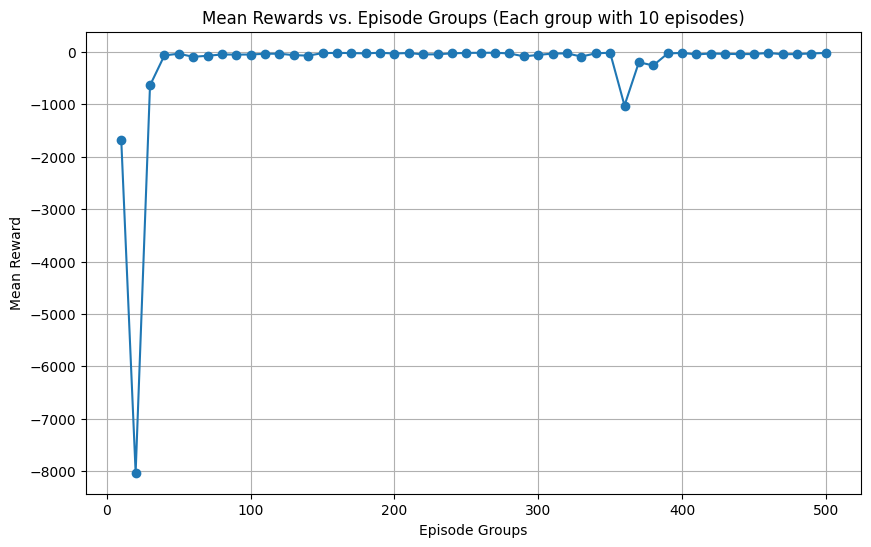

In [35]:
episodes_per_group = 10
episode_numbers = range(episodes_per_group, episodes + 1, episodes_per_group)

plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, plotting_rewards_MonteCarlo, marker ='o', linestyle='-')
plt.title('Mean Rewards vs. Episode Groups (Each group with 10 episodes)')
plt.xlabel('Episode Groups')
plt.ylabel('Mean Reward')
plt.grid(True)
plt.show()

На почетокот може да се забележи  значителен пад на просечната награда, што покажува дека агентот добил многу ниска вкупна награда во текот на првите неколку епизоди. Ова е типично за reinforcement learning, каде што почетната изведба може да биде слаба бидејќи агентот почнува да учи од својата околина. По почетните епизоди средната вредност на наградата се стабилизира. Ова сугерира дека перформансите на агентот станале поконзистентни како што научил од околината. Со текот на времето, средните награди се постојано поблиску до 0 со помалку негативни скокови. Ова имплицира дека агентот учи со текот на времето, што доведува до подобри значајни награди.
Ако ја разгледуваме групата што одговара на епизодата 50, има забележителен скок надолу каде што просечната награда нагло се намалува. Ова може да се должи на неколку фактори, како на пр. дека агентот истражува помалку профитабилни стратегии или аномалија во episode batch.

In [36]:
env_MC = gym.make('CliffWalking-v0', render_mode="human")
n_episodes=1
for episode in range(n_episodes):
    observation = env_MC.reset()
    done = False
    episode_steps = []
    rewards=[]
    
    
    while not done:
        env_MC.render()
        state = get_observation_idx(observation) 
        action = epsilon_greedy_policy(state, Q_table, epsilon)
        next_observation, reward, done, *_ = env_MC.step(action)
       # episode_steps.append((state, action, reward))
        observation = next_observation
env_MC.close()

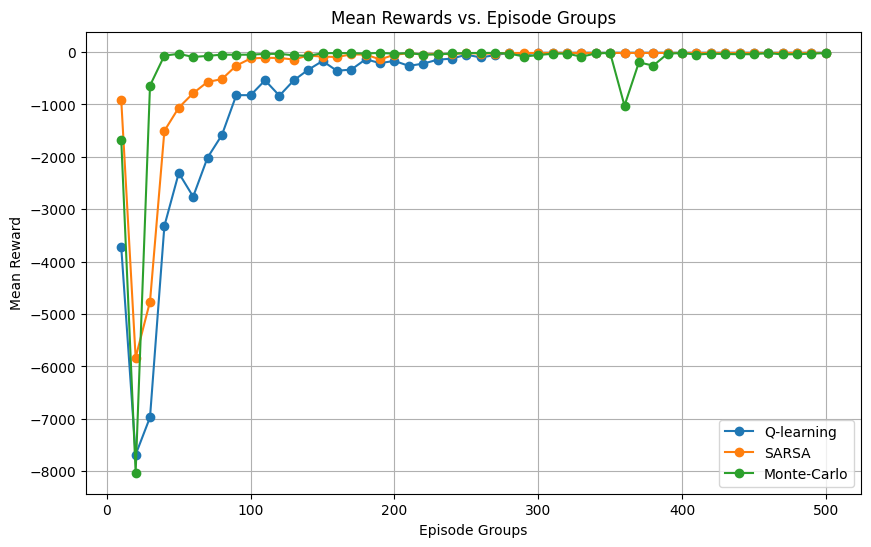

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, plotting_rewards, marker='o', linestyle='-', label='Q-learning')
plt.plot(episode_numbers, plotting_rewards_Sarsa, marker='o', linestyle='-', label='SARSA')
plt.plot(episode_numbers, plotting_rewards_MonteCarlo, marker='o', linestyle='-', label='Monte-Carlo')
plt.title('Mean Rewards vs. Episode Groups')
plt.xlabel('Episode Groups')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

## Заклучок
Од добиениот график може да се заклучи дека:
- Q-учењето се карактеризира со стабилно, но постепено подобрување на средните награди, што укажува на ефикасна, но побавна стапка на учење во почетните епизоди. Алгоритмот постепено се стабилизира, што сугерира дека има добра рамнотежа помеѓу истражувањето и експлоатацијата во оваа средина. После 300та епизода, се одржува стабилна средна награда, што значи дека агентот наоѓа оптимална или речиси оптимална патека за оваа задача;
- SARSA покажува побрзо подобрување на средните награди во споредба со Q-учењето,што сугерира дека учи побрзо на почетокот на процесот на тренирање. Ова може да се должи на неговата оn-policy nature, каде што учи од тековната стратегија, вклучувајќи ги и истражувачките потези.Со овој алгоритам, вредноста на средната награда се приближува до слично ниво како Q-учењето, што покажува дека на крајот ќе најде стратегија што е исто толку ефикасна во оваа средина. Кривата на учење на SARSA е помазна од онаа на Monte Carlo, со помала варијанса во наградите, што сугерира поконзистентна изведба од епизода до епизода;
- Методот Monte Carlo првично покажува значителна варијанса, при што средните награди почнуваат многу ниски, но нагло се подобруваат. Ова е показател за неговата висока варијанса во раните фази на учење поради неговиот метод на учење на целосни епизоди. На крајот достигнува и одржува перформанси споредливи со Q-learning и SARSA, што покажува дека и покрај првичната варијанса, може да најде ефективна стратегија. Методот Monte Carlo не се подигнува како Q-learning и SARSA (кои ги ажурираат своите проценки врз основа на други проценки), наместо тоа, тој учи директно од цели епизоди, што може да ги објасни почетните флуктуации. Откако ќе се земат примероци од доволно епизоди, перформансите на методот Monte Carlo укажуваат дека тој е способен да научи стратегија која е добра како и другите два методи за оваа конкретна задача.